In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [27]:
movies = pd.read_csv('./data/ml-25m/movies.csv')
ratings = pd.read_csv('./data//ml-25m/ratings.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Exploratory Data Analysis

Number of ratings: 100836
Number of unique movieId's: 9742
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.35


/var/folders/v1/9bj9hm895kzbdfh4gwzky7t80000gn/T/ipykernel_7691/3256190647.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


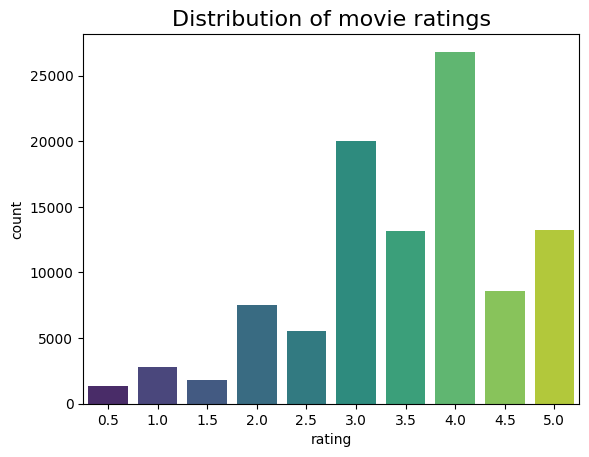

Mean global rating: 3.5
mean rating per user: 3.66


In [28]:
n_ratings = len(ratings)
n_movies = movies['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of movie ratings', fontsize=16)
plt.show()

print(f"Mean global rating: {round(ratings['rating'].mean(), 2)}")
print(f"mean rating per user: {round(ratings.groupby('userId')['rating'].mean().mean(), 2)}")

#### What are the most frequently rated movies

In [29]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

### Movies with the lowest and highest average ratings

In [30]:
mean_ratings=movie_ratings.groupby('movieId')['rating'].mean()
lowest_rated = mean_ratings.idxmin()
movies[movies['movieId']==lowest_rated]


,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [31]:
ratings[ratings['movieId']==lowest_rated]

,userId,movieId,rating,timestamp
13633,89,3604,0.5,1520408880


In [32]:
highest_rated = mean_ratings.idxmax()
movies[movies['movieId']==highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [33]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


In [34]:
movie_stats=ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429
...,...,...
193581,1,4.000000
193583,1,3.500000
193585,1,3.500000


#### Computing Bayesian average 

[Bayesian Average](https://en.wikipedia.org/wiki/Bayesian_average) 



where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$.
 - $C$ represents the typical data set size. In this case, $C$ will be the average number of ratings for a given movie.
- $m$ represents the average rating across all movies



In [35]:
 C = movie_stats['count'].mean()
 m = movie_stats['mean'].mean()

print(f"Average number of ratings per movie: {C: .2f}")
print(f"Average rating per movie: {m: .2f}")

def bayesian_average(ratings, C=C, m=m):
    bayesian_avg = (C*m + ratings.sum())/(C + ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_average).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId',how='left')
movie_stats = movie_stats.merge(movies[['movieId','title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head(10)

Average number of ratings per movie:  10.37
Average rating per movie:  3.26


,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236457,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227052,Fight Club (1999)
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)"
921,1221,129,4.259690,4.185490,"Godfather: Part II, The (1974)"
461,527,220,4.225000,4.181672,Schindler's List (1993)
913,1213,126,4.250000,4.174905,Goodfellas (1990)
6693,58559,149,4.238255,4.174762,"Dark Knight, The (2008)"
897,1196,211,4.215640,4.170989,Star Wars: Episode V - The Empire Strikes Back...


#### A glimpse a the genre

In [36]:
from collections import Counter

movies['genres']=movies['genres'].apply(lambda x: x.split('|'))
genre_frequency = Counter(genre for genres in movies['genres'] for genre in genres)

print(f"There are {len(genre_frequency)} genres")
print(f"The 10 most common genres: {genre_frequency.most_common(10)}")

genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'frequency']
genre_frequency_df.sort_values('frequency', ascending=False, inplace=True)
genre_frequency_df

There are 20 genres
The 10 most common genres: [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596), ('Adventure', 1263), ('Crime', 1199), ('Sci-Fi', 980), ('Horror', 978), ('Fantasy', 779)]


,genre,frequency
6,Drama,4361
3,Comedy,3756
9,Thriller,1894
7,Action,1828
5,Romance,1596
0,Adventure,1263
8,Crime,1199
12,Sci-Fi,980
10,Horror,978
4,Fantasy,779


/var/folders/v1/9bj9hm895kzbdfh4gwzky7t80000gn/T/ipykernel_7691/4286465306.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genre', y='frequency', data=genre_frequency_df, palette='viridis')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Drama'),
  Text(1, 0, 'Comedy'),
  Text(2, 0, 'Thriller'),
  Text(3, 0, 'Action'),
  Text(4, 0, 'Romance'),
  Text(5, 0, 'Adventure'),
  Text(6, 0, 'Crime'),
  Text(7, 0, 'Sci-Fi'),
  Text(8, 0, 'Horror'),
  Text(9, 0, 'Fantasy'),
  Text(10, 0, 'Children'),
  Text(11, 0, 'Animation'),
  Text(12, 0, 'Mystery'),
  Text(13, 0, 'Documentary'),
  Text(14, 0, 'War'),
  Text(15, 0, 'Musical'),
  Text(16, 0, 'Western'),
  Text(17, 0, 'IMAX'),
  Text(18, 0, 'Film-Noir'),
  Text(19, 0, '(no genres listed)')])

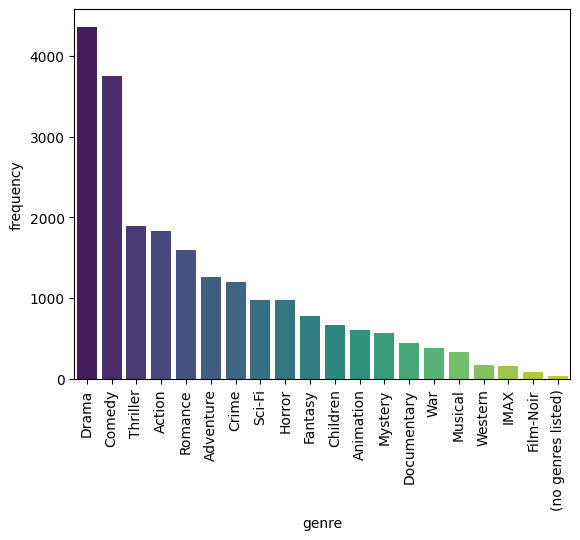

In [37]:
sns.barplot(x='genre', y='frequency', data=genre_frequency_df, palette='viridis')
plt.xticks(rotation=90)

### Data Preprocessing

In [38]:
from scipy.sparse import csr_matrix

def create_utility_matrix(df):
    """ creates a utility matrix from a ratings dataframe 
    Args:
        df (pandas.DataFrame): dataframe of movie ratings containing 
                               'userId', 'movieId' and 'rating' columns
    
    Returns:
        X: sparse matrix of shape (n_users, n_movies)
        user_mapper (dict): dict that maps user id's to user indices
        user_inv_mapper (dict): dict that maps user indices to user id's
        movie_mapper (dict): dict that maps movie id's to movie indices
        movie_inv_mapper (dict): dict that maps movie indices to movie id's
    """

    n_users = df['userId'].nunique()
    n_movies = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(n_users))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(n_movies))))

    user_inv_mapper = dict(zip(list(range(n_users)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(n_movies)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(n_users, n_movies))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [39]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_utility_matrix(ratings)

#### Evaluating sparcity

In [40]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparcity = (1 - (n_ratings/n_total))*100
density = (n_ratings/n_total)*100
print(f"Matrix sparcity: {sparcity: .4f}%")
print(f"Matrix density: {density: .4f}%")

Matrix sparcity:  98.3000%
Matrix density:  1.7000%


In [41]:
n_ratings_per_user = X.getnnz(axis=1)
n_ratings_per_movie = X.getnnz(axis=0)
print(f"{len(n_ratings_per_user), len(n_ratings_per_movie)}") 
print(f"Most active user rated {n_ratings_per_user.max()} movies")
print(f"Least active user rated {n_ratings_per_user.min()} movies")
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings")

(610, 9724)
Most active user rated 2698 movies
Least active user rated 20 movies
Most rated movie has 329 ratings
Least rated movie has 1 ratings


/var/folders/v1/9bj9hm895kzbdfh4gwzky7t80000gn/T/ipykernel_7691/2880289109.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True, color='g')
/var/folders/v1/9bj9hm895kzbdfh4gwzky7t80000gn/T/ipykernel_7691/2880289109.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_movie, shade=True, color='r')


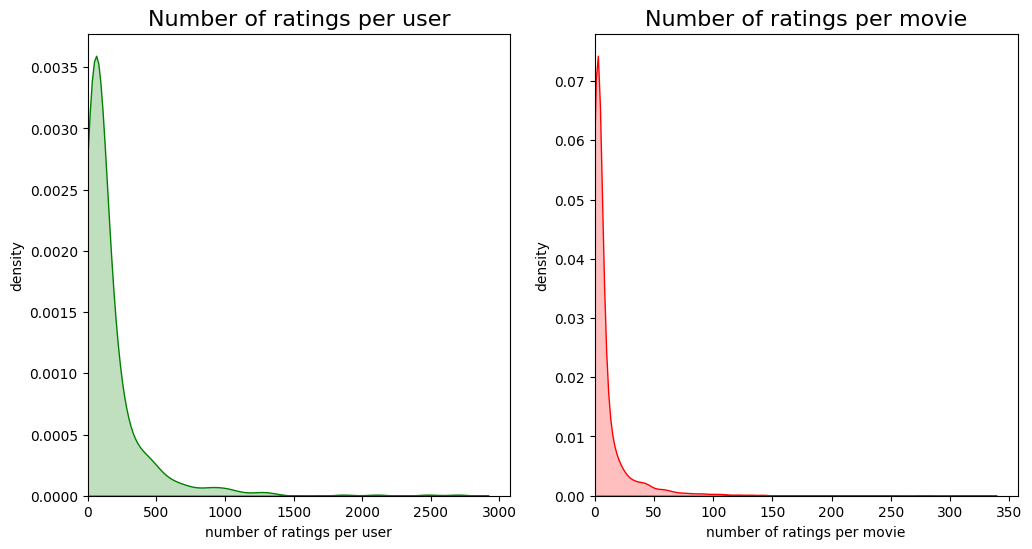

In [42]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(n_ratings_per_user, shade=True, color='g')
plt.xlim(0)
plt.title('Number of ratings per user', fontsize=16)
plt.xlabel('number of ratings per user')
plt.ylabel('density')
plt.subplot(1, 2, 2)
sns.kdeplot(n_ratings_per_movie, shade=True, color='r')
plt.xlim(0)
plt.title('Number of ratings per movie', fontsize=16)
plt.xlabel('number of ratings per movie')
plt.ylabel('density')
plt.show()

In [43]:
print(f"Most active user rated {n_ratings_per_user.max()} movies")
print(f"Least active user rated {n_ratings_per_user.min()} movies")
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings")

Most active user rated 2698 movies
Least active user rated 20 movies
Most rated movie has 329 ratings
Least rated movie has 1 ratings


### Recommend movies based on a watched movie using machine learning 

In [44]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [45]:
movie_titles=dict(zip(movies['movieId'], movies['title']))

movie_id=180
movie_title=movie_titles[movie_id]
similar_movies = find_similar_movies(movie_id,X,movie_mapper,movie_inv_mapper,10)
similar_movie_titles = [movie_titles[i] for i in similar_movies]


In [46]:
print(f"Because you watched {movie_title}:")
for i in similar_movie_titles:
    print(i)

Because you watched Mallrats (1995):
Jay and Silent Bob Strike Back (2001)
Dogma (1999)
Clerks (1994)
Waterboy, The (1998)
Billy Madison (1995)
Wayne's World (1992)
Antitrust (2001)
Team America: World Police (2004)
Chasing Amy (1997)


### Cold start problems
#### 1. New user
#### 2. No ratings for a movie

In [47]:
n_movies=movie_ratings['movieId'].nunique()
print(f"There are {n_movies} movies in the dataset")

genres= set(g for genre in movies['genres'] for g in genre)

for g in genres:
    movies[g]=movies['genres'].transform(lambda x: int(g in x))

movie_genres=movies.drop(['movieId','title','genres'],axis=1)


There are 9724 movies in the dataset


In [48]:
from fuzzywuzzy import process
from sklearn.metrics.pairwise import cosine_similarity
def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

def find_similar_genre_moves(title, n_recommendations=10):
    cosine_sim = cosine_similarity(movie_genres, movie_genres)
    movie_idx = dict(zip(movies['title'], list(movies.index)))
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    return movies['title'].iloc[[i[0] for i in sim_scores]].tolist()



In [49]:
title = movie_finder('Batman')
print(f"Because you watched {title}:")
find_similar_genre_moves(title,4)

Because you watched Batman Forever (1995):


['Batman Forever (1995)',
 "It's a Mad, Mad, Mad, Mad World (1963)",
 'I Spy (2002)',
 'Nothing to Lose (1997)']